In [1]:
import os
import re
from Bio import SeqIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
from scipy import stats
from collections import defaultdict
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

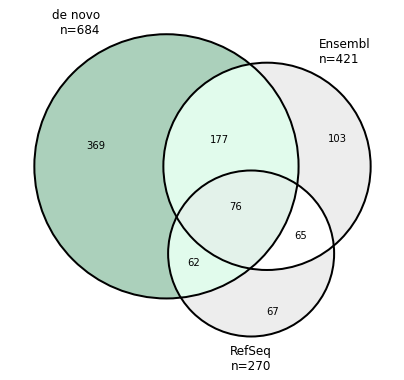

In [2]:
with open('../data/finz_znf_overlap_70.txt') as infile:
    overlap = [int(line.split()[-1]) for line in infile]
ndenovo = overlap[0] + overlap[2] + overlap[4] + overlap[6]
nensembl = overlap[1] + overlap[2] + overlap[5] + overlap[6]
nrefseq = overlap[3] + overlap[4] + overlap[5] + overlap[6]

# (A, B, AB, C, AC, BC, ABC)
fig, ax = plt.subplots(figsize=(7, 7))
venn3(subsets=overlap, 
      set_labels=(f'de novo\nn={ndenovo}', f'Ensembl\nn={nensembl}', f'RefSeq\nn={nrefseq}'), 
      set_colors=('seagreen', 'lightgrey', 'lightgrey'),)
venn3_circles(subsets=overlap)
fig.savefig('../figs/annotation_venn.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/annotation_venn.png', bbox_inches='tight', dpi=300)
plt.show()

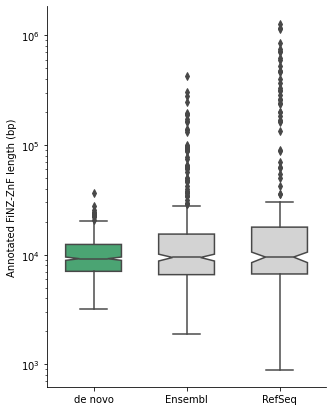

    source  count          mean            std     min      25%     50%  \
0  Ensembl  421.0  20123.560570   39940.273811  1883.0  6583.00  9437.0   
1   RefSeq  281.0  60732.729537  174045.252735   899.0  6676.00  9517.0   
2  de novo  684.0  10003.375731    4036.218736  3188.0  7053.25  9202.5   

       75%        max       iqr  
0  15419.0   421032.0   8836.00  
1  17839.0  1278443.0  11163.00  
2  12405.0    36845.0   5351.75  


In [3]:
annotations = {'de novo': '/Users/jonwells/Projects/feschottelab/finz-znf/data/gffs/Danio_rerio_hiqual_finz.gff',
               'Ensembl': '../data/gffs/ensembl_finz_znf.gff',
               'RefSeq': '../data/gffs/refseq_finz_znf.gff'}
genelengths = defaultdict(list)
for key, filename in annotations.items():    
    with open(filename) as infile:
        for line in infile:
            if "\tgene\t" in line:
                line = line.split()
                genelengths['length'].append(abs(int(line[4]) - int(line[3])))
                genelengths['source'].append(key)
length_df = pd.DataFrame.from_dict(genelengths)
# length_df['log10_length'] = np.log(length_df['length'])

fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(data=length_df, y='length', x='source', 
            palette=['mediumseagreen', 'lightgrey', 'lightgrey'],
            notch=True,
            width=0.6,
            ax=ax)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Annotated FiNZ-ZnF length (bp)')
sns.despine()
plt.show()
fig.savefig('../figs/annotation_lengths.pdf', bbox_inches='tight')
fig.savefig('../figs/annotation_lengths.png', bbox_inches='tight')

length_summary = length_df.groupby('source')['length'].describe().reset_index()
length_summary['iqr'] = length_summary['75%'] - length_summary['25%']
print(length_summary)

In [4]:
def calc_busco(buscofile, value):
    buscopat = '\s+C:([\d\.]+)%\[S:([\d\.]+)%,D:([\d\.]+)%\],F:([\d\.]+)%,M:([\d\.]+)%,n:(\d+)'
    with open(buscofile) as infile:
        for line in infile:
            hit = re.search(buscopat, line)
            if hit:
                vals = [float(i) for i in hit.groups()]
                busco = dict(zip(('complete', 
                                  'singleton', 
                                  'duplicate', 
                                  'failed', 
                                  'missing', 
                                  'n'), 
                                 vals))
                break
    return busco[value]


In [23]:
with open('../data/species_genomes.txt') as infile:
    cyprinids = [line.split()[0] for line in infile]
n50_df = pd.read_csv('/Users/jonwells/Projects/feschottelab/metazoan-znfs/data/parsed_metazoans.out', 
                     sep='\t', header=None)[[0, 3]].rename({0: 'species', 3: 'N50'}, axis=1)
n50_df = n50_df.loc[n50_df.species.isin(cyprinids)]

print(n50_df)

                              species       N50
158               Anabarilius_grahami   4459447
707                 Carassius_auratus  22763433
822                     Chanos_chanos  50300218
1025          Ctenopharyngodon_idella  35662356
1033                  Culter_alburnus   3669388
1077                  Cyprinus_carpio  29545497
1096                 Danio_aesculapii  55996547
1097               Danio_albolineatus   4632361
1098                    Danio_choprai   5707536
1099              Danio_jaintianensis  18165534
1100                    Danio_kyathit  64228523
1101                    Danio_tinwini  13583820
1102               Danionella_dracula  10287669
1103           Danionella_translucida    340819
1667                Gobiocypris_rarus  36586440
1908      Hypophthalmichthys_molitrix    314181
1989                      Labeo_catla    719175
1991                     Labeo_rohita   1959535
2102               Leuciscus_waleckii  21959719
2259         Megalobrama_amblycephala  4

In [11]:
buscos = []
for species in genomes.keys():
    print(species)
    buscofile = f'../data/busco-out/{species}/short_summary.specific.actinopterygii_odb10.{species}.txt'
    buscos.append((species, calc_busco(buscofile, 'complete')))
busco_df = pd.DataFrame(buscos, columns=['species', 'busco_complete'])

Chanos_chanos
Cyprinus_carpio
Ctenopharyngodon_idella
Sinocyclocheilus_anshuiensis
Sinocyclocheilus_rhinocerous
Sinocyclocheilus_grahami
Sinocyclocheilus_maitianheensis
Sinocyclocheilus_anophthalmus
Carassius_auratus
Oxygymnocypris_stewartii
Anabarilius_grahami
Labeo_rohita
Labeo_catla
Hypophthalmichthys_molitrix
Triplophysa_siluroides
Triplophysa_tibetana
Triplophysa_dalaica
Gobiocypris_rarus
Paracanthobrama_guichenoti
Puntigrus_tetrazona
Culter_alburnus
Megalobrama_amblycephala
Onychostoma_macrolepis
Leuciscus_waleckii
Danionella_dracula
Danionella_translucida
Danio_albolineatus
Danio_jaintianensis
Danio_choprai
Danio_aesculapii
Danio_kyathit
Danio_tinwini
Danio_rerio


In [24]:
qc_df = pd.merge(n50_df, busco_df, on='species')
qc_df = pd.merge(pd.read_csv('../data/finz_te_counts.txt', sep='\t')[['species', 'finz_znf', 'finz_exons']], qc_df, on='species')
qc_df = qc_df.sort_values('N50').reset_index().drop('index', 1)
print(qc_df)

                  species  finz_znf  finz_exons       N50  busco_complete
0  Danionella_translucida         9           5    340819            90.9
1      Danio_albolineatus       334         563   4632361            78.4
2           Danio_choprai        64          92   5707536            72.7
3             Danio_rerio       684         892   7379053            95.9
4      Danionella_dracula         4           3  10287669            89.9
5           Danio_tinwini        96         150  13583820            81.1
6     Danio_jaintianensis        93         111  18165534            86.6
7        Danio_aesculapii       389         439  55996547            95.3
8           Danio_kyathit       593         804  64228523            96.0


<ipython-input-24-d559d45299a5>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  qc_df = qc_df.sort_values('N50').reset_index().drop('index', 1)


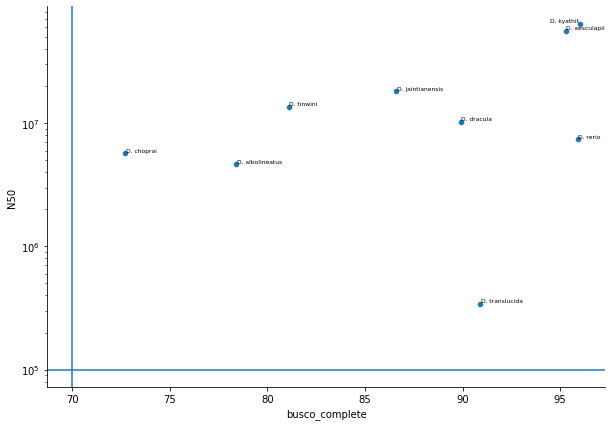

In [25]:
min_n50 = 1e05
min_busco = 70
with open('../data/hiqual_species.txt', 'w') as outfile:
    spec = list(qc_df.loc[(qc_df.N50 > min_n50) & (qc_df.busco_complete > min_busco), 'species'])
    outfile.write('\n'.join(spec))
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=qc_df, x='busco_complete', y='N50')
ax.set_yscale('log')
ax.axvline(x=min_busco)
ax.axhline(y=min_n50)
labels = []
for row in qc_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['busco_complete'], row[1]['N50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
fig.savefig('../figs/n50_vs_busco.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/n50_vs_busco.png', bbox_inches='tight', dpi=300)

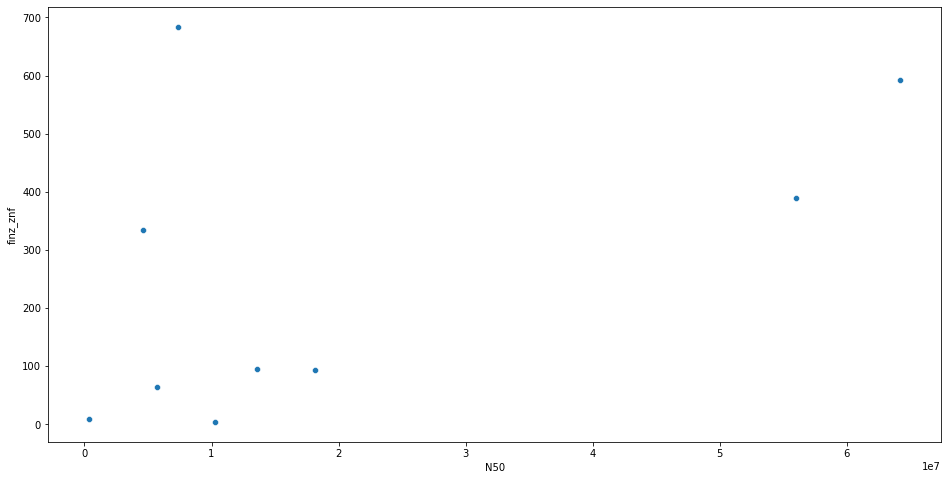

In [26]:
# # Before
# qc_df = qc_df.loc[qc_df.finz+ > 0]
# print(stats.spearmanr(qc_df['nfinz'], qc_df['N50']))
# print(stats.spearmanr(qc_df['nfinz'], qc_df['busco_complete']))

# # After
# print(stats.spearmanr(qc_df.loc[qc_df.species.isin(spec), 'nfinz'],
#                       qc_df.loc[qc_df.species.isin(spec), 'N50']))
# print(stats.spearmanr(qc_df.loc[qc_df.species.isin(spec), 'nfinz'],
#                       qc_df.loc[qc_df.species.isin(spec), 'busco_complete']))
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=qc_df.loc[qc_df.finz_exons >= 0], 
                x='N50',
                y='finz_znf',
                ax=ax)
# sns.scatterplot(data=qc_df.loc[qc_df.finz_exons >= 0], 
#                 x='busco_complete',
#                 y='finz_znf',
#                 ax=ax[0][1])
# sns.scatterplot(data=qc_df.loc[(qc_df.finz_exons >= 0) & (qc_df.species.isin(spec))], 
#                 x='N50',
#                 y='finz_znf',
#                 ax=ax[1][0])
# sns.scatterplot(data=qc_df.loc[(qc_df.finz_exons >= 0) & (qc_df.species.isin(spec))], 
#                 x='busco_complete',
#                 y='finz_znf',
#                 ax=ax[1][1])

# ax[0][0].set_xscale('log')
# ax[1][0].set_xscale('log')

plt.show()

In [27]:
coverage_df = pd.DataFrame(columns=['gene', 'position', 'depth', 'busco', 'species'])
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    df = pd.read_csv(f'../data/danio-reads/{species}_depth75.out', 
                     sep='\t', 
                     header=None, 
                     names=['gene', 'position', 'depth'])
    df['busco'] = False
    df.loc[df.gene.str.contains('\d+at\d+'), 'busco'] = True
    df['species'] = species
    coverage_df = pd.concat([coverage_df, df])
coverage_df['depth'] = coverage_df.depth.apply(pd.to_numeric)
genecov_df = coverage_df.groupby(['species', 'gene', 'busco']).median().reset_index()
print(genecov_df.head())

              species                             gene  busco  depth
0  Danio_albolineatus  Danio_albolineatus_100028at7898   True   16.0
1  Danio_albolineatus  Danio_albolineatus_100034at7898   True   14.0
2  Danio_albolineatus  Danio_albolineatus_100316at7898   True   16.0
3  Danio_albolineatus  Danio_albolineatus_100418at7898   True   13.0
4  Danio_albolineatus  Danio_albolineatus_100571at7898   True   15.0


In [28]:
genecov_df['norm'] = 0
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    genecov_df.loc[genecov_df.species == species, 'norm'] = genecov_df.loc[genecov_df.species == species, 'depth'] - genecov_df.loc[genecov_df.species == species, 'depth'].mean()
 


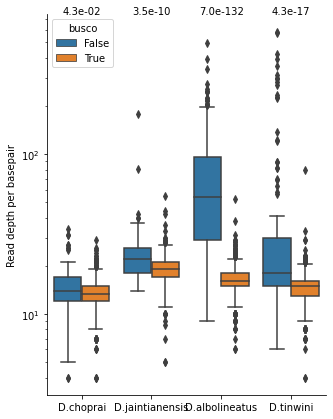

In [29]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=genecov_df, 
            x='species', 
            y='depth', 
            hue='busco', 
            order=['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini'],
            ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Read depth per basepair')
ax.set_xlabel('')
ax.set_xticklabels(['D.choprai', 'D.jaintianensis', 'D.albolineatus', 'D.tinwini'])

i = 0
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    pval = stats.ranksums(genecov_df.loc[(genecov_df.species == species) & (genecov_df.busco == True), 'depth'],
                          genecov_df.loc[(genecov_df.species == species) & (genecov_df.busco == False), 'depth'])[1]
    ax.text(x=i, y=750, s=f'{pval:.1e}', horizontalalignment='center')
#     ax.axline((i-0.1, 750), (i+0.1, 750))
    i += 1

sns.despine()
plt.show()
fig.savefig('../figs/busco_fznf_read_coverage.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/busco_fznf_read_coverage.png', bbox_inches='tight', dpi=300)

In [32]:
print(genecov_df.groupby(['species', 'busco'])['depth'].median())

species              busco
Danio_albolineatus   False    53.50
                     True     16.00
Danio_choprai        False    14.00
                     True     13.25
Danio_jaintianensis  False    22.00
                     True     19.00
Danio_tinwini        False    18.00
                     True     15.00
Name: depth, dtype: float64


In [3]:
gff_files = {'newannot': '../data/gffs/Danio_rerio_hiqual_finz.gff',
             'ensembl': '../data/gffs/ensembl_finz_znf.gff',
             'refseq': '../data/gffs/refseq_finz_znf.gff'}

gffs = {}

for source, filename in gff_files.items():
    gffs[source] = defaultdict(int)
    if source == 'newannot':
        id_pattern = re.compile('ID=(\w+)')
    elif source == 'ensembl':
        id_pattern = re.compile('gene_id=(.+)?;')
    elif source == 'refseq':
        id_pattern = re.compile('gene=(.+)?;')
    
    with open(filename) as infile:
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] == 'gene':
                gid = re.search(id_pattern, line[-1]).group(1)
            elif line[2] == 'CDS':
                gffs[source][gid] += 1


exon_df = pd.DataFrame(columns=['gene', 'exons', 'source'], dtype=int)
for source, exons in gffs.items():
    exon_df = pd.concat([exon_df, pd.DataFrame([(key, val, source) for key, val in exons.items()], columns=['gene', 'exons', 'source'])])
gene_counts = exon_df.groupby('source').count()['gene'].to_dict()
exon_df = exon_df.groupby(['source', 'exons']).count().reset_index()
exon_df['prop'] = exon_df.apply(lambda x: 100*x.gene/gene_counts[x.source], axis=1)
print(exon_df.head())


    source  exons  gene       prop
0  ensembl      2   235  55.819477
1  ensembl      3    27   6.413302
2  ensembl      4    75  17.814727
3  ensembl      5    27   6.413302
4  ensembl      6    20   4.750594


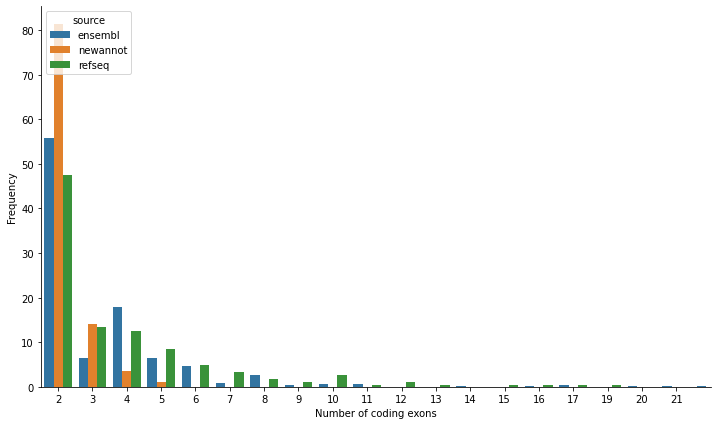

In [4]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data=exon_df, x='exons', hue='source', y='prop')
# sns.kdeplot(data=exon_df, x='exons', hue='source', bw=0.1)
ax.set_xticks([i for i in range(1, 20)])
ax.set_xlim(0.5, 20)
ax.set_xlabel('Number of coding exons')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()

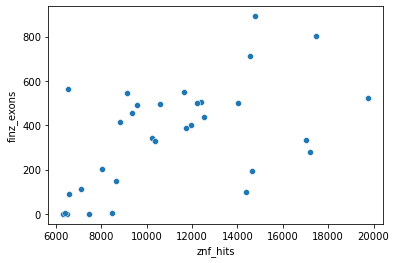

SpearmanrResult(correlation=0.5353869080176333, pvalue=0.0015908330926018852)


In [6]:
df = pd.read_csv('../data/finz_te_counts.txt', sep='\t')
sns.scatterplot(data=df, x='znf_hits', y='finz_exons')
plt.show()
print(stats.spearmanr(df.znf_hits, df.finz_znf))

## Comparing TE annotation quality

In [25]:
def parse_dnapipete_family_counts():
    dnapipete_annots_data = {}
    for sp in os.listdir('../data/dnaPipeTE-out'):
        tedict = {}
        for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'others']:
            i = 0
            with open(f'../data/dnaPipeTE-out/{sp}/Annotation/{teclass}.headers') as infile:
                for line in infile:
                    i += 1
            tedict[teclass] = i
        dnapipete_annots_data[sp] = tedict
    df = pd.DataFrame.from_dict(dnapipete_annots_data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df.sum(axis=1)
    return df.sort_values('species')

def parse_rmodeller_out():
    rmlibs = {
    'Danio_aesculapii': 'fDanAes4.curated_primary.20190724.fa.align.parseRM.all-repeats.tab',
    'Danio_albolineatus': 'fDanAlb1.curated_primary.20190208.fa.align.parseRM.all-repeats.tab',
    'Danio_choprai': 'fDanCho1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
    'Danionella_dracula': 'fDanDra1.1.fa.align.parseRM.all-repeats.tab',
    'Danio_jaintianensis': 'fDanJai1.curated_primary.20190227.fa.align.parseRM.all-repeats.tab',
    'Danio_kyathit': 'fDanKya3.curated_primary.20190802.fa.align.parseRM.all-repeats.tab',
    'Danio_tinwini': 'fDanTin1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
    'Danionella_transclucida': 'fDanTra1.curated_assembly.fa.align.parseRM.all-repeats.tab',
    'Danio_rerio': 'fDreABz2.toplevel_curated.20190410.fa.align.parseRM.all-repeats.tab'
    }
    data = {}
    for species, filename in rmlibs.items():
        tedict = defaultdict(int)
        with open(f'../data/repeatmasker-out/{filename}') as infile:
            infile.readline()
            infile.readline()
            for line in infile:
                line = line.split()
                tedict[line[1]] += 1
        data[species] = tedict
    df = pd.DataFrame.from_dict(data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df.sum(axis=1) 
    return df.sort_values('species')
        


SpearmanrResult(correlation=0.8166666666666667, pvalue=0.007224785246358786)

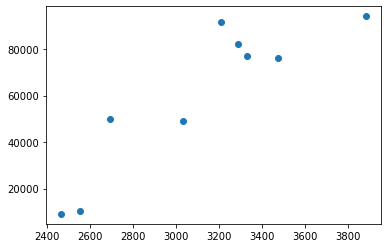

In [30]:
rmodeller_df = parse_rmodeller_out()
dnapipete_df = parse_dnapipete_family_counts()
plt.scatter(rmodeller_df.interspersed, dnapipete_df.loc[dnapipete_df.species.str.startswith('Danio'), 'interspersed'])
stats.spearmanr(rmodeller_df.interspersed, dnapipete_df.loc[dnapipete_df.species.str.startswith('Danio'), 'interspersed'])